This notebook demostrates how to use several ML algorigthms for the text classification task. The models built for this purpose in this notebook are:

1) Multinomial NB

2) Logistic Regression

3) SVM

4) Random Forest Classifier

5) LSTM + GLOVE

6) BERT

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import spacy
import re

from collections import Counter
import seaborn as sns 
import plotly.express as px
import string
import itertools
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn import metrics
from sklearn.metrics import roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Utils

In [2]:
# Function to plot the accuracy and validation loss across training and test set

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [3]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)


## Data loading

In [4]:
data_train = pd.read_csv('train.csv', usecols=['id','text','target'])

data_test = pd.read_csv('test.csv', usecols=['id','text'])

In [5]:

data_train.head(5)

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


## Data Exploration

In [6]:
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'samples')

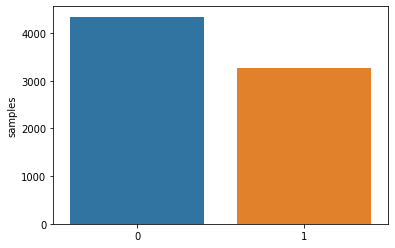

In [7]:
x = data_train.target.value_counts()
sns.barplot(x.index, x)
plt.gca().set_ylabel('samples')

Text(0.5, 0.98, 'Characters in text')

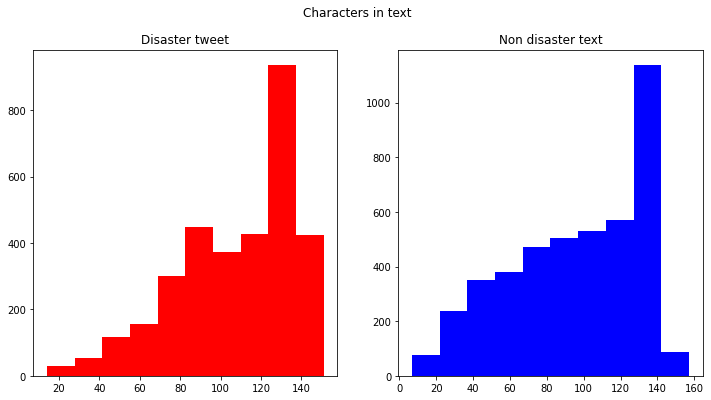

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

train_len1 = data_train[data_train['target']==1]['text'].str.len()
ax1.hist(train_len1, color='red')
ax1.set_title('Disaster tweet')


train_len2= data_train[data_train['target']==0]['text'].str.len()
ax2.hist(train_len2, color='blue')
ax2.set_title('Non disaster text')

fig.suptitle('Characters in text')

### Removing special characters and expanding abbreviations

In [9]:
stop_words = set(stopwords.words("english"))


def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [10]:
data_train['text'] =data_train['text'].apply(clean_text)

In [11]:
data_train['text']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    the out of control wild fires in california ev...
7610               m194 [0104 utc]5km s of volcano hawaii
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

### Data exploration

In [12]:
def preprocess_text(df):
    head_lines = list()
    lines = df["text"].values.tolist()

    full_text=[]

    for line in lines:
        full_text.append(' '.join([w for w in line.split(' ') if w not in stop_words]))

    df['text']=full_text
    return df

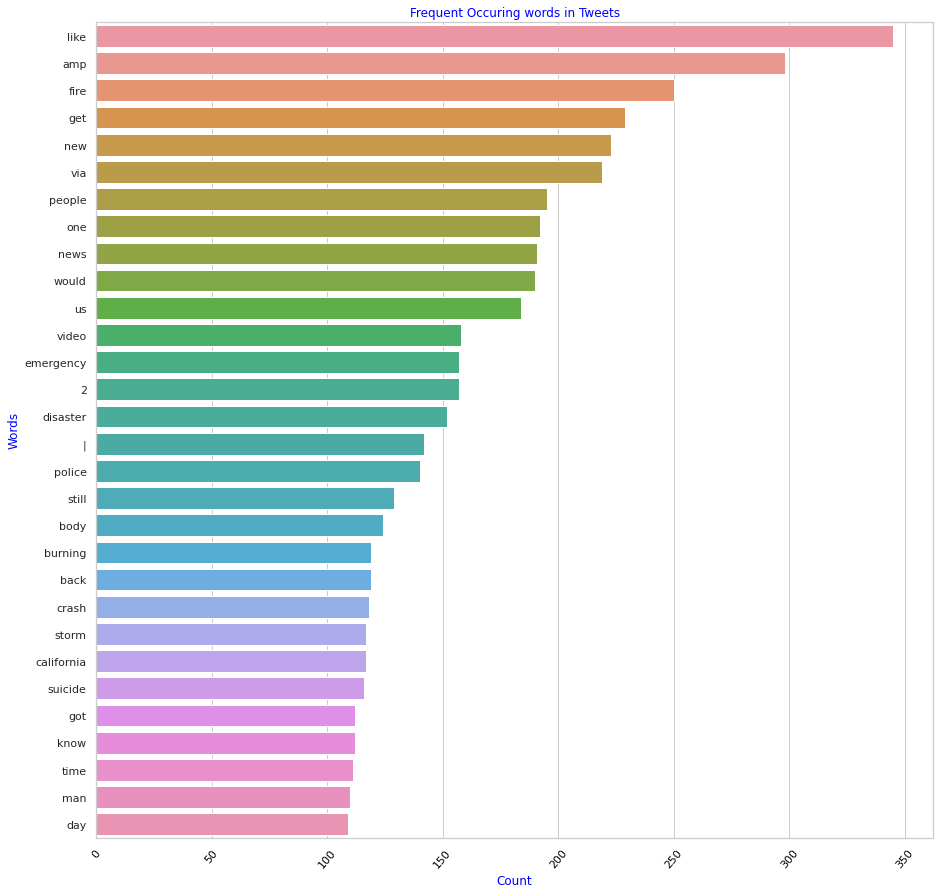

In [13]:
 ## Most common words


df = preprocess_text(data_train)
text=df['text']

words = text.str.split(expand=True).unstack()
result_count = Counter(words).most_common()
result_df = pd.DataFrame(result_count).reset_index().drop(0) #converting to Dataframe and drop the Nones values


#visualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 15)) 
sns.barplot(y=result_df[0][0:30], x=result_df[1][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Frequent Occuring words in Tweets", color="blue") 
plt.xticks(rotation=50);
ax.tick_params(axis='x', colors='black')
plt.show()

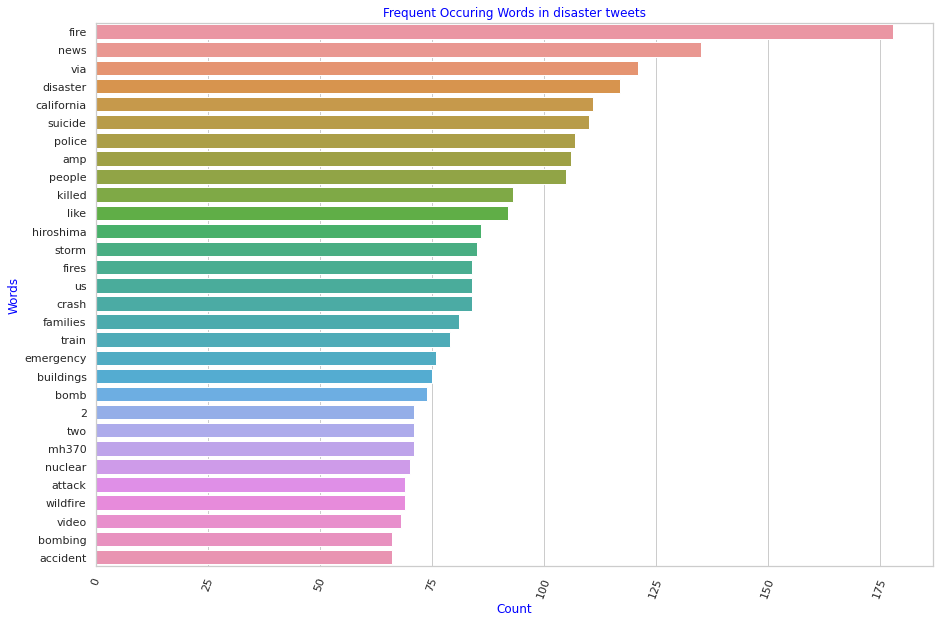

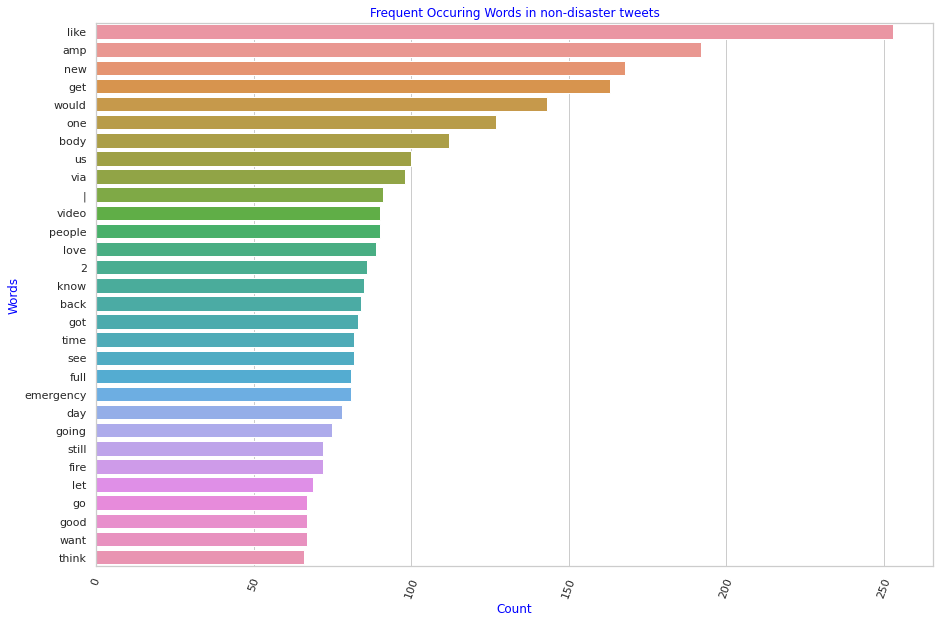

In [14]:
disaster = pd.DataFrame(df[df['target']==1]['text'].str.split(expand=True).unstack().value_counts()).reset_index()
non_disaster = pd.DataFrame(df[df['target']==0]['text'].str.split(expand=True).unstack().value_counts()).reset_index()


#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 10)) 
sns.barplot(y=disaster['index'][0:30], x=disaster[0][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Frequent Occuring Words in disaster tweets", color="blue") 
plt.xticks(rotation=70);
plt.show()


#vizualize result
sns.set_theme(style="whitegrid") 
f, ax = plt.subplots(figsize=(15, 10)) 
sns.barplot(y=non_disaster['index'][0:30], x=non_disaster[0][0:30], data=result_df, palette=None)
plt.ylabel('Words', color="blue")  # Add an x-label to the axes.
plt.xlabel('Count', color="blue")  # Add a y-label to the axes.
plt.title("Frequent Occuring Words in non-disaster tweets", color="blue") 
plt.xticks(rotation=70);
plt.show()

## Modeling

#### Steps:

1 Split the data into training and test sets (80-20 split)

2 Extract features from the training data using CountVectorizer.

3 Transform the test data into the same feature vector as the training data.

4 Train the classifier

5 Evaluate the classifier

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data_train['text'], data_train['target'], test_size=0.2,random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6090,) (6090,)
(1523,) (1523,)


### Multinomial NB


(6090, 13647) (1523, 13647)
CPU times: user 3.69 ms, sys: 819 µs, total: 4.51 ms
Wall time: 4.38 ms
Accuracy:  0.8076165462902167
ROC_AOC_Score:  0.8532453543039682


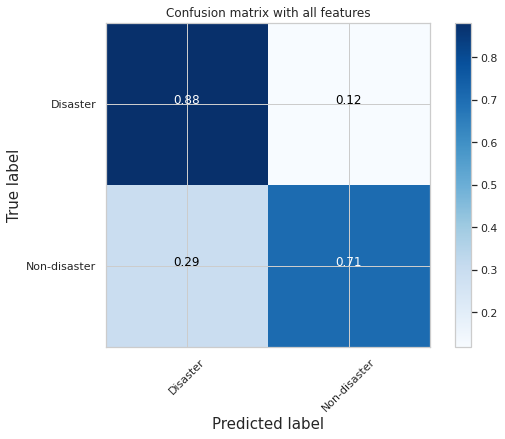

In [16]:
vect = CountVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm.shape, X_test_dtm.shape)


nb = MultinomialNB()
%time nb.fit(X_train_dtm, y_train) 
y_pred_class = nb.predict(X_test_dtm)


# Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

    
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Disaster','Non-disaster'],normalize=True,
                      title='Confusion matrix with all features')

# calculate AUC:
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]
print("ROC_AOC_Score: ", roc_auc_score(y_test, y_pred_prob))

### Logistic Regression

Accuracy:  0.7944845699277742
AUC:  0.8532453543039682


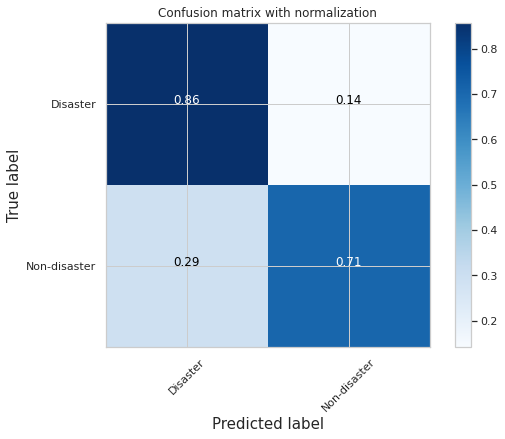

In [17]:
from sklearn.linear_model import LogisticRegression 

logreg = LogisticRegression(class_weight="balanced") 
logreg.fit(X_train_dtm, y_train) 

y_pred_class = logreg.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Disaster','Non-disaster'],normalize=True,
                      title='Confusion matrix with normalization')

### SVM

Accuracy:  0.778069599474721
AUC:  0.8532453543039682


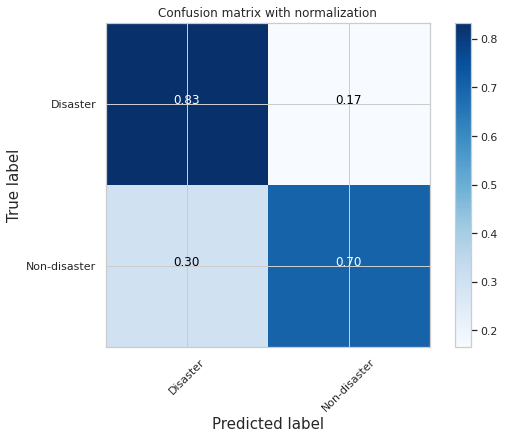

In [18]:
from sklearn.svm import SVC

vect = CountVectorizer(max_features=2000) 
X_train_dtm = vect.fit_transform(X_train) 
X_test_dtm = vect.transform(X_test)

classifier = SVC(kernel = 'linear', random_state = 0, class_weight='balanced') 
classifier.fit(X_train_dtm, y_train) 

# Make predictions on test data
y_pred_class = classifier.predict(X_test_dtm)

# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Disaster','Non-disaster'],normalize=True,
                      title='Confusion matrix with normalization')


### Random Forest

Accuracy:  0.7570584372948129
AUC:  0.8532453543039682


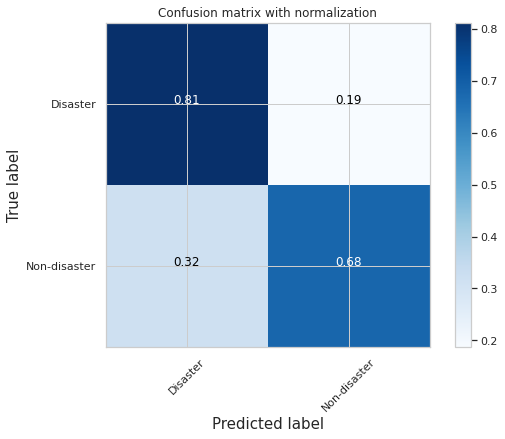

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier=RandomForestClassifier(n_estimators=10)

rf_classifier.fit(X_train_dtm,y_train)
y_pred_class=rf_classifier.predict(X_test_dtm)


# calculate evaluation measures:
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("AUC: ", roc_auc_score(y_test, y_pred_prob))
cnf_matrix = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8,6))
plot_confusion_matrix(cnf_matrix, classes=['Disaster','Non-disaster'],normalize=True,
                      title='Confusion matrix with normalization')

## LSTM with Glove

##### Load glove and embeddings




In [20]:
%%capture
try:
    
    from google.colab import files
    
    !wget -P DATAPATH http://nlp.stanford.edu/data/glove.twitter.27B.zip
    !unzip DATAPATH/glove.twitter.27B.zip -d DATAPATH/glove.twitter.27B

    
    BASE_DIR = 'DATAPATH'
    
except ModuleNotFoundError:
    
    if not os.path.exists('Data/glove.6B'):
        os.mkdir('Data/glove.6B')
        
        url='http://nlp.stanford.edu/data/glove.twitter.27B.zip'  
        wget.download(url,'Data')  
  
        temp='Data/glove.twitter.27B.zip' 
        file = ZipFile(temp)  
        file.extractall('Data/glove.twitter.27B') 
        file.close()
        

    
    BASE_DIR = 'Data'

import os

GLOVE_DIR = os.path.join(BASE_DIR, 'glove.twitter.27B')

In [21]:
sequence_length = data_train['text'].apply(lambda x : len(x.split()))
MAX_SEQUENCE_LENGTH =max(sequence_length)

MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 200 
VALIDATION_SPLIT = 0.2

In [22]:


tokenizer= Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data_train['text'])
train_sequences = tokenizer.texts_to_sequences(data_train['text'])

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 15835 unique tokens.


In [23]:
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)

trainvalid_labels = data_train['target'].values


# creating an index to shuffle the train and test dataset
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)


trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])
x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]


#### Embedding layer

In [24]:
embeddings_index={}

with open('/content/DATAPATH/glove.twitter.27B/glove.twitter.27B.200d.txt', encoding='utf8') as f:
  for line in f:
    values=line.split()
    word=values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] =coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))

num_words = min(MAX_NUM_WORDS, len(word_index)) + 1

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# note that we set trainable is set to False  to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
print("Preparing of embedding matrix is done")

Found 1193514 word vectors in Glove embeddings.
Preparing of embedding matrix is done


In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

history = model.fit(x_train, y_train, batch_size=64, epochs=3, validation_data=(x_val, y_val), verbose=2)


Epoch 1/3
96/96 - 15s - loss: 0.5048 - acc: 0.7562 - val_loss: 0.4409 - val_acc: 0.8022 - 15s/epoch - 160ms/step
Epoch 2/3
96/96 - 9s - loss: 0.4260 - acc: 0.8146 - val_loss: 0.4341 - val_acc: 0.8141 - 9s/epoch - 93ms/step
Epoch 3/3
96/96 - 9s - loss: 0.4061 - acc: 0.8215 - val_loss: 0.4294 - val_acc: 0.8081 - 9s/epoch - 94ms/step


In [26]:
# model = Sequential()
# model.add(Embedding(MAX_NUM_WORDS, 128))
# model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
# print('Training the RNN')

# history = model.fit(x_train, y_train,
#           batch_size=64,
#           epochs=10,
#           validation_data=(x_val, y_val))

In [27]:
# show_history(history)

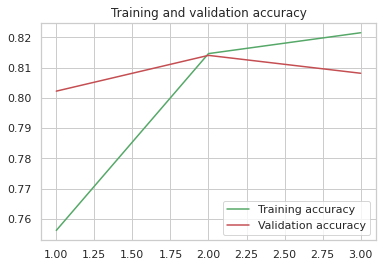

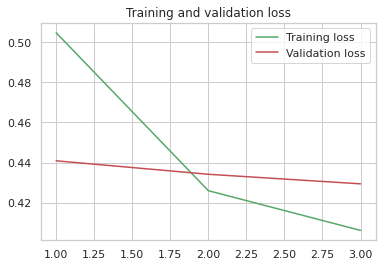

In [28]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
def predict_text(s):

    s= clean_text(s)
    tokens = word_tokenize(s)
    test_sequences = tokenizer.texts_to_sequences(tokens)
    print(test_sequences)
    test_review_pad = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(test_review_pad)
    if pred[0][0]>=0.5: return "Disaster post!" 
    else: return "It's not a disaster post."

In [30]:
predict_text("There was a flood here.	")

[[], [], [12833], [123], []]


"It's not a disaster post."

In [31]:
print(tokenizer.texts_to_sequences(['fire burned house']))

[[3, 250, 200]]


## BERT

In [32]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 23.8 MB/s 
     |████████████████████████████████| 6.6 MB 50.0 MB/s 
     |████████████████████████████████| 163 kB 65.8 MB/s 


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [34]:
from transformers import AutoTokenizer, TFBertModel

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [35]:
SEQ_LENGTH= max(len(x.split()) for x in data_train.text)

max_len =SEQ_LENGTH

In [36]:
tokenized_text = tokenizer(data_train['text'].tolist(),
                           max_length=SEQ_LENGTH,
                           truncation= True,
                           padding='max_length',
                           add_special_tokens= True, return_token_type_ids= False,
                           return_attention_mask= True, return_tensors='tf')

X_input_ids = tokenized_text['input_ids']
X_attention_mask = tokenized_text['attention_mask']

In [37]:
arr = data_train['target'].values
label= np.zeros((arr.size, max(arr)+1))
label[np.arange(arr.size), arr]=1

In [38]:
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attention_mask, label ))

In [39]:
for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(25,), dtype=int32, numpy=
array([  101, 15616,  3114,  8372,  2089, 16455,  9641,  2149,   102,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0], dtype=int32)>, <tf.Tensor: shape=(25,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)>, <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0., 1.])>)


In [40]:
def map_function(input_ids, masks, label):
  return({'input_ids':input_ids,'attention_mask':masks},label)

dataset=dataset.map(map_function)

In [41]:
dataset= dataset.shuffle(1000).batch(32)

LEN_DF= len(list(dataset))
split=0.9

train_ds= dataset.take(round(split*LEN_DF))
val_ds= dataset.skip(round(split*LEN_DF))

In [42]:
input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

embeddings= bert.bert(input_ids, attention_mask)[1]

out= tf.keras.layers.Dropout(0.1)(embeddings)
out= tf.keras.layers.Dense(128, activation='relu')(out)
out= tf.keras.layers.Dropout(0.1)(out)
out= tf.keras.layers.Dense(32, activation='relu')(out)
y= tf.keras.layers.Dense(2, activation='softmax')(out)

model= tf.keras.Model(inputs=[input_ids,attention_mask], outputs=y)

model.layers[2].trainable= False

In [43]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss= tf.keras.losses.CategoricalCrossentropy()
# acc= tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss= loss, metrics=['accuracy'])

history= model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=64)


Epoch 1/30
214/214 [==============================] - 45s 95ms/step - loss: 0.7066 - accuracy: 0.5289 - val_loss: 0.6773 - val_accuracy: 0.5647
Epoch 2/30
214/214 [==============================] - 16s 75ms/step - loss: 0.6858 - accuracy: 0.5603 - val_loss: 0.6700 - val_accuracy: 0.6078
Epoch 3/30
214/214 [==============================] - 16s 76ms/step - loss: 0.6695 - accuracy: 0.5919 - val_loss: 0.6470 - val_accuracy: 0.6588
Epoch 4/30
214/214 [==============================] - 16s 75ms/step - loss: 0.6631 - accuracy: 0.6018 - val_loss: 0.6393 - val_accuracy: 0.6497
Epoch 5/30
214/214 [==============================] - 17s 78ms/step - loss: 0.6550 - accuracy: 0.6133 - val_loss: 0.6177 - val_accuracy: 0.7268
Epoch 6/30
214/214 [==============================] - 16s 76ms/step - loss: 0.6444 - accuracy: 0.6310 - val_loss: 0.6016 - val_accuracy: 0.7150
Epoch 7/30
214/214 [==============================] - 16s 76ms/step - loss: 0.6396 - accuracy: 0.6425 - val_loss: 0.6104 - val_accuracy:

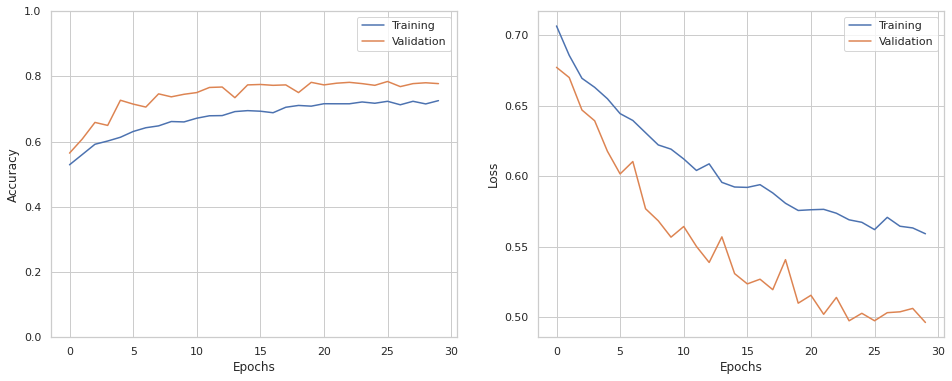

In [44]:
show_history(history)

In [45]:
def prep_text(text):
  tokens= tokenizer.encode_plus(text, max_length = SEQ_LENGTH,
                                truncation=True, padding='max_length',
                                add_special_tokens=True, return_token_type_ids=False,
                                return_tensors='tf')
  return{
      'input_ids': tf.cast(tokens['input_ids'], tf.float64),
      'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)
  }


test =prep_text("The movie was fire")
probs=model.predict(test)

np.argmax(probs[0])

0